<a href="https://colab.research.google.com/github/haritejaachandu4-boop/SCT_DS_4/blob/main/SKILL_CRAFT_TASK_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Path to dataset files: /kaggle/input/india-road-accident-dataset-predictive-analysis
Loaded rows: 3000
Columns: ['State Name', 'City Name', 'Year', 'Month', 'Day of Week', 'Time of Day', 'Accident Severity', 'Number of Vehicles Involved', 'Vehicle Type Involved', 'Number of Casualties', 'Number of Fatalities', 'Weather Conditions', 'Road Type', 'Road Condition', 'Lighting Conditions', 'Traffic Control Presence', 'Speed Limit (km/h)', 'Driver Age', 'Driver Gender', 'Driver License Status', 'Alcohol Involvement', 'Accident Location Details']

Top states:
 State Name
Goa                  109
Sikkim               108
Delhi                108
Uttarakhand          106
Jammu and Kashmir    105
Kerala               102
Tamil Nadu           101
Nagaland             101
Gujarat              100
Puducherry            98
Name: count, dtype: int64

Top cities:
 City Name
Unknown       2138
New Delhi       39
Surat           38
Lucknow         38
Dwarka          38
Coimbatore      37
Mysore         

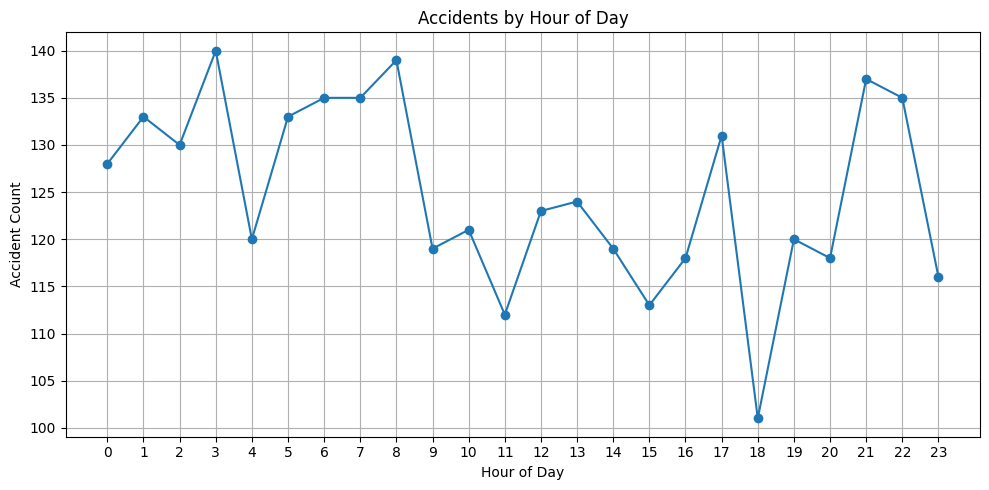


Interactive hotspot map saved at: /content/accident_analysis_outputs/accident_hotspots_map.html


In [4]:
# Traffic Accident Analysis & Visualization with Hotspot Mapping
# Run this in Google Colab. Upload your CSV before running.

# --- Install required packages ---
!pip install geopy folium -q

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import folium
from geopy.geocoders import Nominatim
import os, warnings
warnings.filterwarnings("ignore")

# --- Config ---
import kagglehub

# Download latest version
path = kagglehub.dataset_download("khushikyad001/india-road-accident-dataset-predictive-analysis")

print("Path to dataset files:", path)
CSV_PATH = "/kaggle/input/india-road-accident-dataset-predictive-analysis/accident_prediction_india.csv"   # Upload file in Colab
OUT_DIR = "/content/accident_analysis_outputs"
os.makedirs(OUT_DIR, exist_ok=True)

# --- Load dataset ---
df = pd.read_csv(CSV_PATH)
print("Loaded rows:", len(df))
print("Columns:", df.columns.tolist())

# --- Quick cleaning & normalization ---
required_cols = [
    'State Name','City Name','Year','Month','Day of Week','Time of Day',
    'Accident Severity','Number of Vehicles Involved','Vehicle Type Involved',
    'Number of Casualties','Number of Fatalities','Weather Conditions',
    'Road Type','Road Condition','Lighting Conditions','Traffic Control Presence',
    'Speed Limit (km/h)','Driver Age','Driver Gender','Driver License Status',
    'Alcohol Involvement','Accident Location Details'
]
missing = [c for c in required_cols if c not in df.columns]
if missing:
    raise ValueError(f"Missing expected columns: {missing}")

# Strip whitespace
for c in df.select_dtypes(include=['object']).columns:
    df[c] = df[c].astype(str).str.strip()

# Convert numeric columns
numeric_cols = ['Number of Vehicles Involved','Number of Casualties','Number of Fatalities',
                'Speed Limit (km/h)','Driver Age','Year','Month']
for c in numeric_cols:
    df[c] = pd.to_numeric(df[c], errors='coerce')

# --- Time feature engineering ---
def extract_hour(t):
    if pd.isna(t): return np.nan
    s = str(t).strip()
    try:
        if ":" in s:
            parts = s.split()
            timepart = parts[0]
            hh = int(timepart.split(":")[0])
            if len(parts) > 1:
                ampm = parts[1].lower()
                if ampm.startswith('p') and hh < 12: hh += 12
                if ampm.startswith('a') and hh == 12: hh = 0
            return hh
        if s.lower().endswith(('am','pm')):
            ampm = s[-2:].lower()
            num = s[:-2]
            hh = int(num.split(":")[0]) if ":" in num else int(num)
            if ampm == 'pm' and hh < 12: hh += 12
            if ampm == 'am' and hh == 12: hh = 0
            return hh
        if len(s) in (3,4) and s.isdigit():
            return int(s[:-2])
        if s.isdigit():
            return int(s)
    except:
        return np.nan
    return np.nan

df['Hour'] = df['Time of Day'].apply(extract_hour)

def month_to_num(m):
    if pd.isna(m): return np.nan
    try: return int(m)
    except:
        try: return pd.to_datetime(m, format='%B').month
        except:
            try: return pd.to_datetime(m, format='%b').month
            except: return np.nan

df['MonthNum'] = df['Month'].apply(month_to_num)

if 'Year' in df and df['Year'].notna().any() and df['MonthNum'].notna().any():
    df['pseudo_date'] = pd.to_datetime(dict(
        year=df['Year'].fillna(2000).astype(int),
        month=df['MonthNum'].fillna(1).astype(int),
        day=1))
else:
    df['pseudo_date'] = pd.NaT

# --- Summaries ---
print("\nTop states:\n", df['State Name'].value_counts().head(10))
print("\nTop cities:\n", df['City Name'].value_counts().head(10))

# --- Hotspots ---
city_hotspots = df.groupby(['State Name','City Name']).agg(
    accidents=('City Name','size'),
    fatalities=('Number of Fatalities','sum'),
    casualties=('Number of Casualties','sum')
).reset_index().sort_values('accidents', ascending=False)

city_hotspots.to_csv(os.path.join(OUT_DIR, "city_hotspots_summary.csv"), index=False)

# --- Plot accidents by hour ---
hour_counts = df['Hour'].value_counts().sort_index()
hours = list(range(24))
hour_counts_full = [hour_counts.get(h,0) for h in hours]
plt.figure(figsize=(10,5))
plt.plot(hours, hour_counts_full, marker='o')
plt.xticks(hours)
plt.xlabel("Hour of Day")
plt.ylabel("Accident Count")
plt.title("Accidents by Hour of Day")
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR,"accidents_by_hour.png"))
plt.show()

# --- Geocoding & Folium Map ---
geolocator = Nominatim(user_agent="accident_mapper")

def cached_geocode(city, state, cache={}):
    key = f"{city},{state}"
    if key in cache: return cache[key]
    try:
        loc = geolocator.geocode(f"{city}, {state}, India", timeout=10)
        if loc:
            cache[key] = (loc.latitude, loc.longitude)
            return cache[key]
    except: return (None, None)
    return (None, None)

N = 30
top_cities = city_hotspots.head(N).copy()
top_cities[['lat','lon']] = top_cities.apply(
    lambda r: cached_geocode(r['City Name'], r['State Name']),
    axis=1, result_type="expand")

mapped_cities = top_cities.dropna(subset=['lat','lon'])

m = folium.Map(location=[22.9734,78.6569], zoom_start=5, tiles="CartoDB positron")

for _, row in mapped_cities.iterrows():
    folium.CircleMarker(
        location=[row['lat'], row['lon']],
        radius=max(5,row['accidents']/50),
        popup=folium.Popup(
            f"<b>{row['City Name']}, {row['State Name']}</b><br>"
            f"Accidents: {row['accidents']}<br>"
            f"Fatalities: {row['fatalities']}<br>"
            f"Casualties: {row['casualties']}", max_width=250),
        color="red", fill=True, fill_opacity=0.6
    ).add_to(m)

map_path = os.path.join(OUT_DIR,"accident_hotspots_map.html")
m.save(map_path)
print(f"\nInteractive hotspot map saved at: {map_path}")


m